<a href="https://colab.research.google.com/github/sizhky/AutoTrain/blob/master/nbs/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
# If running on colab, it will crash the first time
# since install_colab.sh restarts this notebook
try:
    from icevision.all import *
except:
    !pip install -U torch-snippets typer imgaug
    !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
    !bash install_colab.sh

In [2]:
# Setup Data
%load_ext autoreload
%autoreload 2

from torch_snippets import *

# If running locally from AutoTrain/nbs
if not os.path.exists('/content') and P().resolve().stem != 'AutoTrain':
    %cd ..

# If running from colab
if os.path.exists('/content') and not os.path.exists('/content/AutoTrain'):
    !git clone https://github.com/sizhky/AutoTrain

if not P().resolve().stem == 'AutoTrain':
    %cd AutoTrain
if not os.path.exists('open-images-bus-trucks/data'):
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz -O open-images-bus-trucks.tar.xz
    unzip_file('open-images-bus-trucks.tar.xz', './')
    P('open-images-bus-trucks').mv('data')
    makedir('open-images-bus-trucks')
    P('data').mv('open-images-bus-trucks/data')
    

Cloning into 'AutoTrain'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (305/305), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 305 (delta 177), reused 180 (delta 83), pack-reused 0
Receiving objects: 100% (305/305), 6.37 MiB | 15.31 MiB/s, done.
Resolving deltas: 100% (177/177), done.
/content/AutoTrain


In [3]:
!cat configs/object_detection.ini

[project]
owner: sizhky
name: open-images-bus-trucks
location: ${project.name}
model_directory: ${project.location}/models
type: object_detection
num_classes: 2
auto_train_lib: auto_train_${project.type}
classes: ["Bus", "Truck"]

[label_studio]
base_data_dir: /tmp/data/

[label_studio_ml]
app_name: ${project.name}/my_ml_model
script_path: ${project.auto_train_lib}/script.py

[online_training]
save_dir: ${project.model_directory}/model.pt

[architecture]
model_type: ultralytics.yolov5
backbone: small
pretrained: True
size: 384
[architecture.extra_args]
img_size: ${architecture.size}

[training]
dir: ${project.location}/data
images_dir: ${training.dir}/images
annotations_file: ${training.dir}/annotations/mini_open_images_train_coco_format.json
train_ratio: 0.8

[training.preprocess]
@augmentations: get_train_transforms
size: ${architecture.size}
presize: 512

[training.data]
train_dir: ${training.dir}/train
validation_dir: ${training.dir}/validation

[training.scheme]
epochs: 25
lr: 1e-

In [ ]:
os.environ['CONFIG'] = 'configs/object_detection.ini'
!python auto_train_object_detection/train.py train-model

15225 images found


  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/409 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/2 [00:00<?, ?it/s]

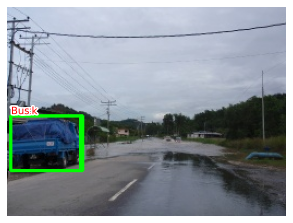

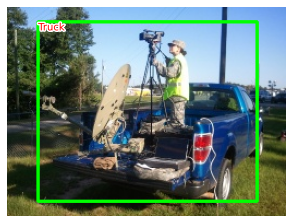

In [5]:
os.environ['CONFIG'] = 'configs/object_detection.ini'
from auto_train_object_detection.infer import predict_on_folder_of_images as infer
o = infer('open-images-bus-trucks/data/images/')

for fpath, pred in o:
    show(read(fpath, 1), bbs=pred.bbs, texts=pred.labels)